## Import Semua Packages/Library yang Digunakan
#### Pada bagian ini, kita mengimpor semua library yang diperlukan untuk proyek, termasuk pandas untuk manipulasi data, tensorflow untuk membangun model neural network, dan seaborn untuk visualisasi data. Juga terdapat perintah untuk mengunggah file jika diperlukan.

In [1]:
# Prepare tools prior coding
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline
import seaborn as sns
import random

In [2]:
# Import library untuk upload key
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1) (1).json


{'kaggle (1) (1).json': b'{"username":"muhammadiqbal1992","key":"0790de54902a2d705f3278a16db81f5b"}'}

## Download dan ekstrak dataset
#### Mengunduh dataset cuaca dari Kaggle dan mengekstraknya agar dapat digunakan dalam analisis selanjutnya.


In [3]:
# Dowload dataset
!kaggle datasets download -d petalme/seattle-weather-prediction-dataset

# Ekstrak dataset
!unzip seattle-weather-prediction-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/petalme/seattle-weather-prediction-dataset
License(s): apache-2.0
seattle-weather-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  seattle-weather-prediction-dataset.zip
replace seattle-weather.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: seattle-weather.csv     


## Load Dataset
#### Memuat dataset yang telah diekstrak ke dalam DataFrame menggunakan pandas.

In [4]:
# Load dataset
data = pd.read_csv('seattle-weather.csv')

## Data Dimension
#### Menampilkan dimensi dataset (jumlah baris dan kolom) untuk memberikan gambaran awal tentang ukuran data.

In [5]:
# Data dimension
data_shape = data.shape
print("Data Dimensions:", data_shape)

Data Dimensions: (1461, 6)


## Cek 5 baris di dataset
#### Memeriksa lima baris pertama dari dataset dan mendapatkan informasi serta statistik deskriptif untuk memahami struktur dan distribusi data.

In [6]:
# Check 5 row in dataset to see how many classes and each label
data.head()

date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [8]:
data.describe()

precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000

## Cek Validitas Data
#### Memeriksa jumlah nilai yang hilang (missing values) dalam setiap kolom untuk menentukan langkah-langkah pembersihan yang diperlukan.
### Pemeriksaan dan Penggantian null
##### Menghitung jumlah nilai nol dalam kolom-kolom tertentu. Nilai nol dianggap sebagai missing value dalam konteks ini.

In [9]:
import missingno as msno
data.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [10]:
date = (data.date == 0).sum()
precipitation = (data.precipitation == 0).sum()
temp_max = (data.temp_max == 0).sum()
wind = (data.wind == 0).sum()
weather = (data.weather == 0).sum()


print("Nilai 0 di kolom date ada: ", date)
print("Nilai 0 di kolom precipitation ada: ", precipitation)
print("Nilai 0 di kolom temp_max ada: ", temp_max)
print("Nilai 0 di kolom wind ada: ", wind)
print("Nilai 0 di kolom weather ada: ", weather)

Nilai 0 di kolom date ada:  0
Nilai 0 di kolom precipitation ada:  838
Nilai 0 di kolom temp_max ada:  2
Nilai 0 di kolom wind ada:  0
Nilai 0 di kolom weather ada:  0


## Encode Fitur "weather" ke Numerik
#### Menggunakan teknik one-hot encoding untuk mengubah fitur kategorikal "weather" menjadi format numerik agar dapat digunakan dalam model machine learning.

In [11]:
one_hot_encoded = pd.get_dummies(data['weather'], prefix='weather')
one_hot_encoded.head()
data = pd.concat([data, one_hot_encoded], axis=1)
data.head()

date  precipitation  temp_max  temp_min  wind  weather  \
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle   
1  2012-01-02           10.9      10.6       2.8   4.5     rain   
2  2012-01-03            0.8      11.7       7.2   2.3     rain   
3  2012-01-04           20.3      12.2       5.6   4.7     rain   
4  2012-01-05            1.3       8.9       2.8   6.1     rain   

   weather_drizzle  weather_fog  weather_rain  weather_snow  weather_sun  
0             True        False         False         False        False  
1            False        False          True         False        False  
2            False        False          True         False        False  
3            False        False          True         False        False  
4            False        False          True         False        False

## Normalisasi Data
####  Mengonversi kolom tanggal menjadi objek datetime dan mengekstrak hari dalam tahun sebagai fitur numerik. Kemudian, normalisasi dilakukan pada fitur numerik lainnya menggunakan MinMaxScaler.

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Convert 'date' column to datetime objects if it's not already
data['date'] = pd.to_datetime(data['date'])

# Extract numerical features from the date (e.g., day of year)
# Here, we extract the day of year as a numerical feature
data['day_of_year'] = data['date'].dt.dayofyear

# Now use MinMaxScaler on the numerical 'day_of_year' column
scaler = MinMaxScaler()
data['day_of_year'] = scaler.fit_transform(data['day_of_year'].values.reshape(-1, 1))

# If you need to scale other numerical columns, do it similarly:
# Exclude 'weather' column as it's categorical
numerical_cols = ['precipitation', 'temp_max', 'temp_min', 'wind']
for col in numerical_cols:
    data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))

data.head()

date  precipitation  temp_max  temp_min      wind  weather  \
0 2012-01-01       0.000000  0.387097  0.476378  0.472527  drizzle   
1 2012-01-02       0.194991  0.327957  0.389764  0.450549     rain   
2 2012-01-03       0.014311  0.357527  0.562992  0.208791     rain   
3 2012-01-04       0.363148  0.370968  0.500000  0.472527     rain   
4 2012-01-05       0.023256  0.282258  0.389764  0.626374     rain   

   weather_drizzle  weather_fog  weather_rain  weather_snow  weather_sun  \
0             True        False         False         False        False   
1            False        False          True         False        False   
2            False        False          True         False        False   
3            False        False          True         False        False   
4            False        False          True         False        False   

   day_of_year  
0     0.000000  
1     0.002740  
2     0.005479  
3     0.008219  
4     0.010959

## Buat diagram heatmap
#### Membuat heatmap untuk menganalisis korelasi antara fitur numerik. Ini membantu dalam memahami hubungan antar variabel.

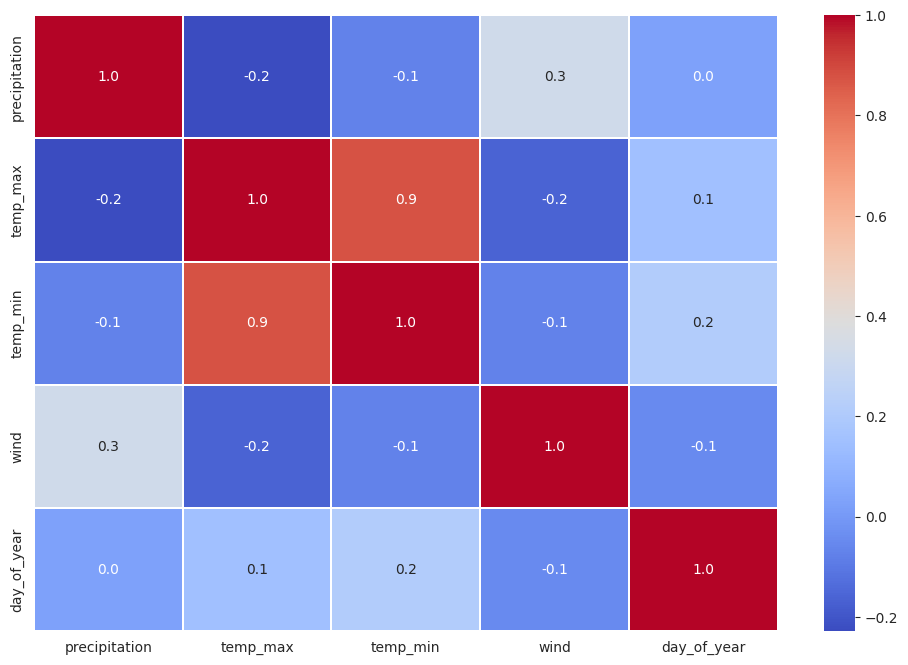

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical features for correlation analysis, including the new encoded column
numerical_data = data.select_dtypes(include=['number'])

sns.set_style('dark')
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), cmap='coolwarm', annot=True, fmt='.1f', linewidths=.1)
plt.show()

## Pemisahan Fitur dan Label
#### Memisahkan dataset menjadi fitur (X) dan label (y), di mana label adalah suhu maksimum yang ingin diprediksi.

In [14]:
X = data.drop(['date', 'weather'], axis=1)
y = data['precipitation']

In [15]:
X.head()

precipitation  temp_max  temp_min      wind  weather_drizzle  weather_fog  \
0       0.000000  0.387097  0.476378  0.472527             True        False   
1       0.194991  0.327957  0.389764  0.450549            False        False   
2       0.014311  0.357527  0.562992  0.208791            False        False   
3       0.363148  0.370968  0.500000  0.472527            False        False   
4       0.023256  0.282258  0.389764  0.626374            False        False   

   weather_rain  weather_snow  weather_sun  day_of_year  
0         False         False        False     0.000000  
1          True         False        False     0.002740  
2          True         False        False     0.005479  
3          True         False        False     0.008219  
4          True         False        False     0.010959

In [16]:
y.head()

0    0.000000
1    0.194991
2    0.014311
3    0.363148
4    0.023256
Name: precipitation, dtype: float64

## CHECK ALL DATA FEATURES
#### Membuat histogram untuk setiap variabel dalam dataset untuk visualisasi distribusi data.

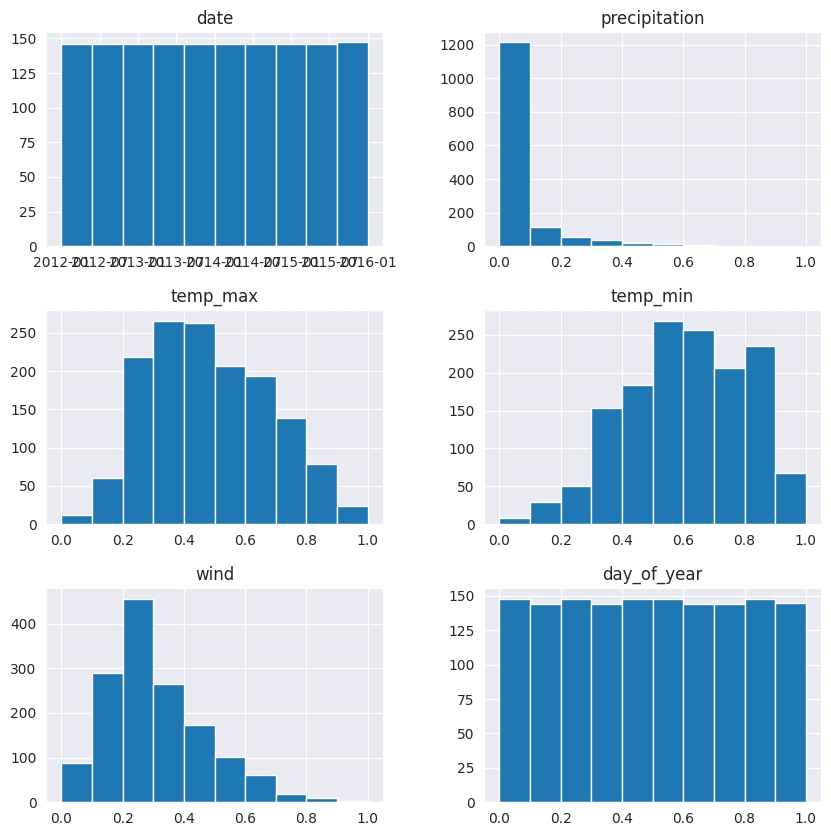

In [17]:
# plot histograms for each variable
data.hist(figsize = (10, 10))
plt.show()

## Membuat model Logistic Regression
#### Mengonversi target variabel menjadi kelas biner berdasarkan ambang batas. Model regresi logistik dilatih dan dievaluasi menggunakan laporan klasifikasi.

In [18]:
# Assuming 'y' is your target variable and it's continuous
# You need to convert it into discrete classes for Logistic Regression

# Example using thresholding to create two classes (0 and 1):
threshold = y.mean() # Or any other suitable threshold
y_binary = (y >= threshold).astype(int)

print(y_binary)

0       0
1       1
2       0
3       1
4       0
       ..
1456    1
1457    0
1458    0
1459    0
1460    0
Name: precipitation, Length: 1461, dtype: int64


In [19]:
from sklearn.preprocessing import StandardScaler # Import the StandardScaler class
from sklearn.model_selection import train_test_split # Import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

In [20]:
# Initialize the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

LogisticRegression()

In [21]:
# Making predictions and evaluating the model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = log_reg.predict(X_test)
print("Logistic Regression Report:\n", (classification_report(y_test, y_pred)))
print("Confusion Matrix Report:\n", (confusion_matrix(y_test, y_pred)))
print("AUC score:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       224
           1       0.99      0.97      0.98        69

    accuracy                           0.99       293
   macro avg       0.99      0.98      0.99       293
weighted avg       0.99      0.99      0.99       293

Confusion Matrix Report:
 [[223   1]
 [  2  67]]
AUC score: 0.9984472049689441


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

y_train: 1168
y_pred: 1168


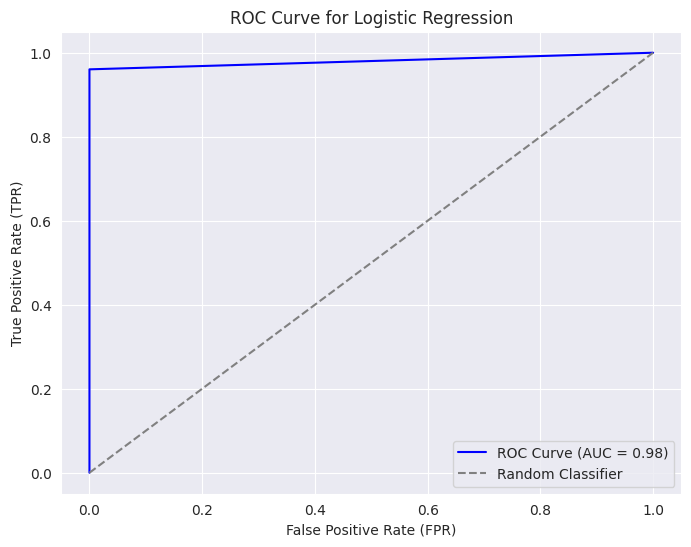

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict probabilities for the training set (using training data)
y_prob = log_reg.predict_proba(X_train)[:, 1]  # Get probabilities for the positive class

# Predict labels for the training set (using training data)
y_train_pred = log_reg.predict(X_train) # Get predicted labels for training set


# Calculate the ROC curve (using training data)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred) # Use y_train_pred

# Calculate the Area Under the Curve (AUC)
auc_score = roc_auc_score(y_train, y_train_pred)  # Use y_train_pred

print("y_train:", len(y_train))
print("y_pred:", len(y_train_pred))

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [24]:
print(X.shape)  # should be (m, n-features)
print(y.shape)  # should be (m) or (m. n_targets)

(1461, 10)
(1461,)


## Membuat model model ANN
#### Membangun dan melatih model Jaringan Saraf Tiruan (ANN) dengan menggunakan optimizer Adam dan fungsi kerugian binary crossentropy. Proses pelatihan mencakup penggunaan early stopping untuk mencegah overfitting.

In [25]:
# Using ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score

# Building the neural network model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
    Dense(1, activation='sigmoid')
])

# Compiling the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7376 - loss: 0.7907 - val_accuracy: 0.7645 - val_loss: 0.4343
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8540 - loss: 0.4379 - val_accuracy: 0.9625 - val_loss: 0.2581
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9412 - loss: 0.2450 - val_accuracy: 0.9932 - val_loss: 0.1334
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9619 - loss: 0.2016 - val_accuracy: 0.9863 - val_loss: 0.1520
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9828 - loss: 0.1498 - val_accuracy: 0.9625 - val_loss: 0.2576
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9664 - loss: 0.1821 - val_accuracy: 0.9898 - val_loss: 0.1083
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9754 - loss: 0.1397 - val_accuracy: 0.9829 - val_loss: 0.1198
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9808 - loss: 0.1502 - val_accuracy: 0.9761 - val_loss:

## Hasil Evaluasi Model ANN
#### Menghitung skor AUC dari model ANN pada data pengujian untuk mengevaluasi kemampuannya dalam membedakan antara kelas positif dan negatif.

In [26]:
# Predicting and evaluating
y_pred = (ann_model.predict(X_train) > 0.5).astype("int32")


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [27]:
print("y_pred:", len(y_pred))
print("y_test:", len(y_test))
print("y_train:", len(y_train))

print("Neural Network Confusion Matrix:\n", confusion_matrix(y_train, y_pred))
print("Neural Network AUC Score:", roc_auc_score(y_test, ann_model.predict(X_test)))

y_pred: 1168
y_test: 293
y_train: 1168
Neural Network Confusion Matrix:
 [[886   4]
 [  0 278]]
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Neural Network AUC Score: 0.9970885093167702


In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
%matplotlib inline

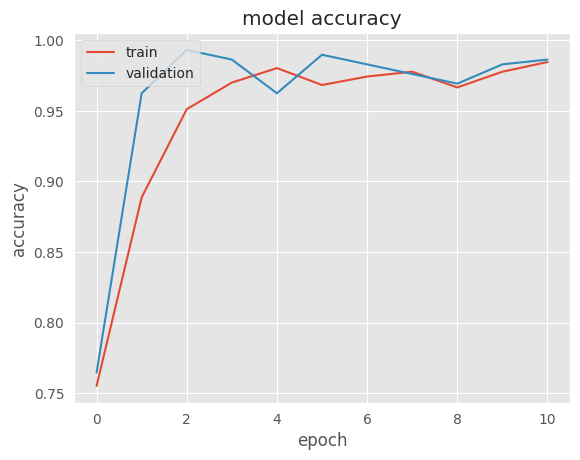

In [29]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

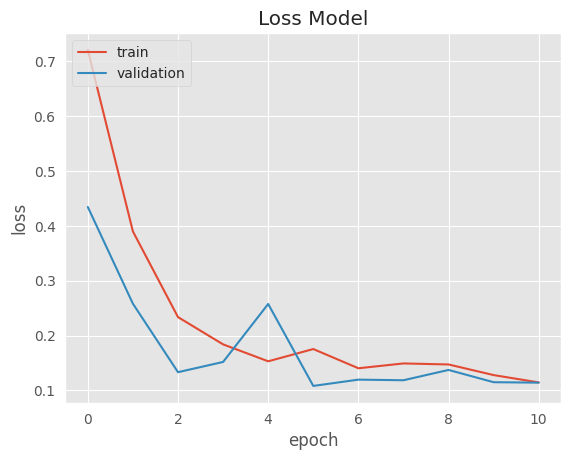

In [30]:
plt.style.use("ggplot")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()